In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [52]:
df = pd.read_csv('spam.csv', encoding='latin-1').iloc[:, :2]
df.rename(columns= {'v1': 'spam', 'v2': 'message'}, inplace=True)
df['spam'] = df['spam'].map({'ham': 0, 'spam': 1})
df.head()

,spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [53]:
df['spam'].value_counts()

spam
0    4825
1     747
Name: count, dtype: int64

### แบ่ง train set 70% test set 30%

In [54]:
all_mails_count = df['spam'].count()

train_data = df.loc[:all_mails_count * 0.7] # 70%
test_data = df.loc[all_mails_count * 0.7 + 1:] # 30%
test_data.reset_index(inplace = True)
test_data.drop(columns='index')
train_data['spam'].value_counts(), test_data['spam'].value_counts()

(spam
 0    3382
 1     519
 Name: count, dtype: int64,
 spam
 0    1442
 1     228
 Name: count, dtype: int64)

In [55]:
"""
function นับจำนวนคำ
@param  data    set ของข้อความ
@return dictionary key = คำที่พบ, value = จำนวน
"""
def count_words(data: set) -> dict:
    counter = dict()
    for message in data:
        for word in message.split(' '):
            if word in counter:
                counter[word] += 1
            else:
                counter[word] = 1
    
    return counter

In [56]:
spam_messages = set(train_data.query('spam == 1')['message'])
spam_words = count_words(spam_messages)

ham_messages = set(train_data.query('spam == 0')['message'])
ham_words = count_words(ham_messages)

In [57]:
def bar_chart_words(words, top=10, messages_type='', color='pink'):
    top_spam = np.array(sorted(words.items(), key=lambda x: -x[1]))[:top]
    top_words = top_spam[::-1, 0]
    top_words_count = [int(i) for i in top_spam[::-1, 1]]

    if messages_type:
        messages_type = messages_type + " "
    plt.figure(figsize=(6, 4))
    plt.title(f"Top {top} most common words in {messages_type}messages")
    plt.xlabel(f"Number of words")
    plt.barh(top_words, top_words_count, color=color)
    plt.show()

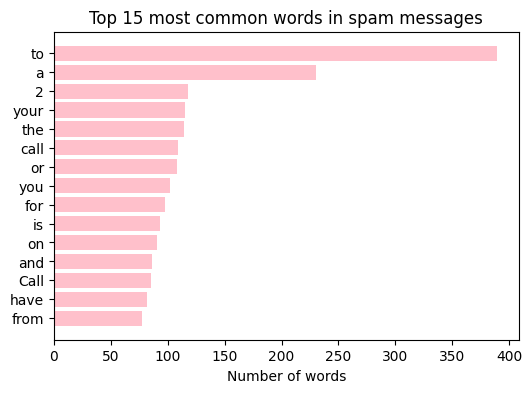

In [58]:
bar_chart_words(spam_words, top=15, messages_type='spam')

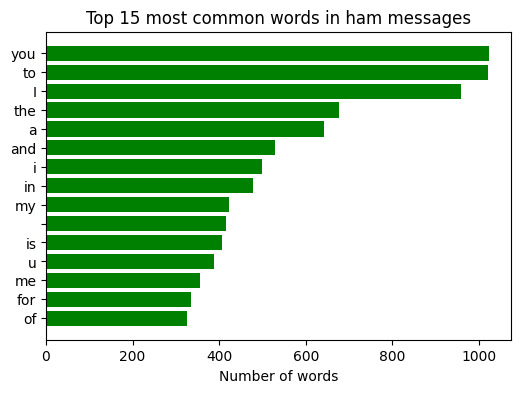

In [59]:
bar_chart_words(ham_words, top=15, messages_type='ham', color='green')

In [60]:
words = pd.read_csv('english_words.csv', encoding='UTF-8', delim_whitespace='\n')
words.rename(columns={'Source-http://www.wordfrequency.info/': 'words'}, inplace=True)
words.head()

,words
0,the
1,and
2,have
3,that
4,for


In [61]:
nltk.download('stopwords')
nltk.download('punkt')
wordlist = set(words['words'])
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\Administrator.LE
[nltk_data]     JER0FQOX6AT6H\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Administrator.LEJER0
[nltk_data]     FQOX6AT6H\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
def process_message(message):
    words = message.lower()
    words = nltk.word_tokenize(words)
    words = [word for word in words if len(word) > 1]
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if word in wordlist]
    words = [nltk.PorterStemmer().stem(word) for word in words]

    return words

In [63]:
def count_processed_words(data):
    counter = dict()
    for message in data:
        words = process_message(message)
        for word in set(words):
            if word in counter:
                counter[word] += 1
            else:
                counter[word] = 1
    
    return counter

In [64]:
spam_words = count_processed_words(spam_messages)
ham_words = count_processed_words(ham_messages)

spam_messages = [i for i in spam_messages if len(process_message(i)) >= 1]
ham_messages = [i for i in ham_messages if len(process_message(i)) >= 1]

all_messages = spam_messages + ham_messages
all_words = count_processed_words(all_messages)

$ P(class|data) = \frac{P(class|data)P(class)}{P(data)} $

In [65]:
def spam(message, s=1, p=0.5):
    n = 0
    spam_freq = 0
    ham_freq = 0
    for word in process_message(message):
        if word in spam_words.keys():
            spam_freq = (spam_words[word] / all_words[word])
        if word in ham_words.keys():
            ham_freq = (ham_words[word] / all_words[word])
        if not (spam_freq + ham_freq) == 0 and word in all_words.keys():
            spaminess_of_word = (spam_freq) /  (spam_freq + ham_freq)
            corr_spaminess = (s * p + all_words[word] * spaminess_of_word) / (s + all_words[word])
            n += np.log(1 - corr_spaminess) - np.log(corr_spaminess)

    spam_result = 1 / (1 + np.e**n)

    print(f'Spam probability: {spam_result * 100:.2f}%')


In [66]:
spam("Join SoftUni, FREE Programming Basics course! Don't miss out on this offer! Become a code wizard GUARANTEED!")

Spam probability: 77.12%


In [67]:
spam("Hey man, SoftUni is pretty great. This Data Science course? Highly recommend.")

Spam probability: 0.00%


In [68]:
spam("Call me when you get home")

Spam probability: 1.10%


In [69]:
spam("Call me now to win a FREE home!")

Spam probability: 49.10%


In [70]:
spam("Call now to win a FREE prize!")

Spam probability: 99.32%
